In [3]:
# Install required packages
%pip install xarray netCDF4 matplotlib cartopy

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import required libraries
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Open the CESM terrain data file
# Immediately select only North America region to avoid loading unnecessary data
file_path = 'fv_1.9x2.5_nc3000_Nsw084_Nrs016_Co120_Fi001_ZR_GRNL_031819.nc'

# North America region: generous coverage to not miss anything
# Latitude: 10°N to 75°N (covers from Panama to Arctic)
# Longitude: 180°E to 320°E (converts to -180°W to -40°W, covers entire North America)
ds = xr.open_dataset(file_path)
na_subset = ds.sel(lat=slice(10, 75), lon=slice(180, 320))

# Only keep PHIS variable we need, drop the rest to save memory
ds = na_subset[['PHIS']]

print("North America subset shape:", ds.PHIS.shape)
print("Latitude range:", float(ds.lat.min()), "to", float(ds.lat.max()))
print("Longitude range:", float(ds.lon.min()), "to", float(ds.lon.max()))

North America subset shape: (35, 57)
Latitude range: 10.421052631578945 to 74.84210526315789
Longitude range: 180.0 to 320.0


In [5]:
# Convert geopotential (PHIS) to elevation in meters
# PHIS is in m^2/s^2, divide by gravity (9.8065 m/s^2) to get elevation
g0 = 9.8065  # Standard gravity in m/s^2
ds["elevation"] = ds.PHIS / g0

# Load the data into memory now (only the subset we need)
ds = ds.load()

# Check the elevation data (verify units are in meters)
print("Elevation range:", float(ds.elevation.min().values), "to", float(ds.elevation.max().values), "meters")
print("(Verified: elevation is in meters, converted from PHIS geopotential)")

Elevation range: 0.0 to 2868.2767368221166 meters
(Verified: elevation is in meters, converted from PHIS geopotential)


In [6]:
# Data is already subsetted to North America in Cell 1
# No need for additional subsetting - we have all of North America
print("Ready to plot North America")
print("Data shape:", ds.elevation.shape)
print("Latitude range:", float(ds.lat.min()), "to", float(ds.lat.max()))
print("Longitude range:", float(ds.lon.min()), "to", float(ds.lon.max()))



Ready to plot North America
Data shape: (35, 57)
Latitude range: 10.421052631578945 to 74.84210526315789
Longitude range: 180.0 to 320.0


Computed grid spacing: lat=1.895°, lon=2.500°


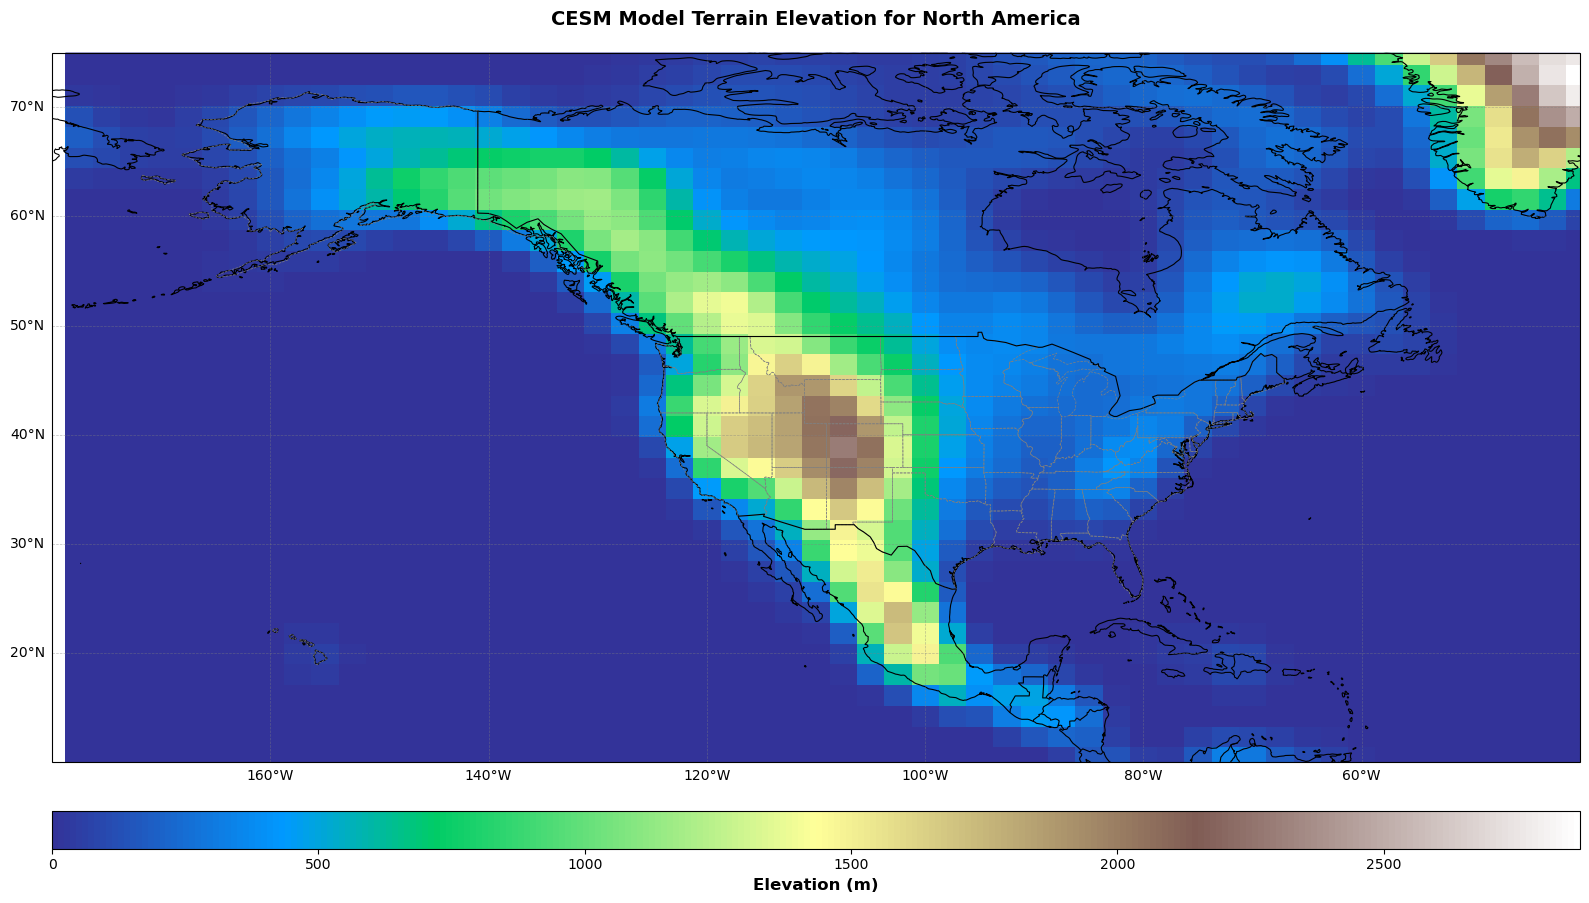

In [7]:
# Create a high-resolution plot with coastlines and state borders
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Get coordinate values (before wrapping longitude)
lon_values_raw = ds.lon.values
lat_values = ds.lat.values
elevation_values = ds.elevation.values

# Convert longitude from 0-360 format to -180-180 format for plotting
# Use np.where to safely wrap only values > 180
lon_values = np.where(lon_values_raw > 180, lon_values_raw - 360, lon_values_raw)

# Compute grid spacing from coordinate arrays themselves
# This ensures accuracy: f19 grid is ~1.9° lat × 2.5° lon
lon_spacing = np.diff(lon_values_raw).mean()
lat_spacing = np.diff(lat_values).mean()

print(f"Computed grid spacing: lat={lat_spacing:.3f}°, lon={lon_spacing:.3f}°")

# Create edge coordinates for pcolormesh
# pcolormesh requires grid cell boundaries, so edges are at ±spacing/2 from cell centers
lon_edges_raw = np.concatenate([[lon_values_raw[0] - lon_spacing/2], 
                                 lon_values_raw + lon_spacing/2])
lat_edges = np.concatenate([[lat_values[0] - lat_spacing/2], 
                            lat_values + lat_spacing/2])

# Wrap longitude edges the same way as cell centers
lon_edges = np.where(lon_edges_raw > 180, lon_edges_raw - 360, lon_edges_raw)

# Create the plot using pcolormesh to show discrete grid cells without smoothing
# shading='auto' adapts to edge/center coordinates automatically
im = ax.pcolormesh(lon_edges, lat_edges, elevation_values, 
                   cmap='terrain', transform=ccrs.PlateCarree(), shading='auto')

# Optional: Add contour line at high elevation threshold (e.g., 2500 m) to highlight major terrain
# Uncomment the following lines to add elevation contours
# CS = ax.contour(lon_values, lat_values, elevation_values,
#                 levels=[2500], colors='k', linewidths=1.5,
#                 transform=ccrs.PlateCarree())
# ax.clabel(CS, inline=True, fontsize=8, fmt='%d m')

# Add coastlines
ax.coastlines(resolution='50m', linewidth=0.8, color='black')

# Add state borders
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray', linestyle='--')

# Add country borders
ax.add_feature(cfeature.BORDERS, linewidth=0.8, edgecolor='black')

# Set the map extent to focus on North America
ax.set_extent([-180, -40, 10, 75], crs=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, aspect=40)
cbar.set_label('Elevation (m)', fontsize=12, fontweight='bold')

# Add title
plt.title('CESM Model Terrain Elevation for North America', 
          fontsize=14, fontweight='bold', pad=20)

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.tight_layout()
plt.show()


In [8]:
# Save as high-resolution PNG for research paper
# Set DPI to 300 for publication quality
output_file = 'CESM_terrain_NA.png'
fig.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
print(f"High-resolution plot saved as: {output_file}")


High-resolution plot saved as: CESM_terrain_NA.png
